In [43]:
import os
import sys
import cv2
import torch
import random
import numpy as np

sys.path.append("../")


In [44]:
from src.io.config import load_yml, load_config
from src.utils.utils import visualize
from src.transform.transform import transform
from src.model.utils import segmentation_model
from src.dataset.road_dataset import RoadDataset
from src.io.io import load_state_dict_from_ckpt, read_rgb
from src.model.segmentation_module import RoadSegmentationModule

In [45]:
output_path = "/Users/riccardomusmeci/progetti/github/output/road-segmentation/2022-05-09-06-12-52"
transform_config, model_config, train_config, dataset_config = load_config(os.path.join(output_path, "config"))

In [46]:
classes = dataset_config["classes"]
classes

['lane', 'crack']

In [47]:
model_config

{'input_size': {'height': 512, 'width': 512},
 'model': 'deeplabv3+',
 'backbone': 'timm-efficientnet-b3',
 'weights': 'imagenet',
 'activation': 'softmax'}

In [50]:
ckpt_path = os.path.join(output_path, "checkpoints", os.listdir(os.path.join(output_path, "checkpoints"))[1])
print(ckpt_path)

/Users/riccardomusmeci/progetti/github/output/road-segmentation/2022-05-09-06-12-52/checkpoints/epoch=6-step=6257-val_loss=0.594-val_iou=0.620.ckpt


In [51]:

model = segmentation_model(
        model=model_config["model"],
        backbone=model_config["backbone"],
        num_classes=len(classes),
        in_channels=3,
        weights=model_config["weights"],
    )

model.load_state_dict(
    state_dict=load_state_dict_from_ckpt(ckpt_path)
)

> Creating segmentation model deeplabv3+ - backbone timm-efficientnet-b3 - weights from imagenet - num_classes 2


<All keys matched successfully>

In [52]:
dataset = RoadDataset(
    data_dir="/Users/riccardomusmeci/progetti/github/dataset/road-segmentation/Dataset",
    classes=classes,
    train=False,
    transform=transform(train=False, **model_config["input_size"])
)

In [53]:
colors = [
    np.array([0, 0, 0], dtype='uint8'),
    np.array([255, 255, 255], dtype='uint8'),
]

In [101]:
image_idx = random.randint(0, len(dataset))
img_path = dataset.images[image_idx] + "_RAW.jpg"
x, mask = dataset[image_idx]
print(image_idx, img_path)

250 /Users/riccardomusmeci/progetti/github/dataset/road-segmentation/Dataset/val/1091974_DF_251_251BDF0490_01271/1091974_DF_251_251BDF0490_01271_RAW.jpg


In [102]:
model.eval()
logits = model(x.unsqueeze(0))[0]
preds = torch.sigmoid(logits)


In [103]:
_preds = preds.detach().numpy().transpose(1, 2, 0)

In [104]:
_preds.shape, _preds.max(), _preds.min()

((512, 512, 2), 0.8077916, 0.19393045)

In [89]:
# _preds[_preds>=0.5] = 1
# _preds[_preds<0.5] = 0

(array([  0,   0,   0, ..., 511, 511, 511]),
 array([  0,   1,   2, ..., 509, 510, 511]),
 array([0, 0, 0, ..., 0, 0, 0]))

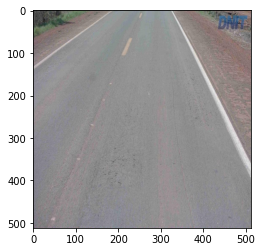

In [105]:
image = read_rgb(img_path)
image = cv2.resize(image, (512, 512))

plt.imshow(image)
# print("Inference")
# visualize(
#     image=image,
#     masks=_preds,
#     classes=classes,
#     colors=colors
# )

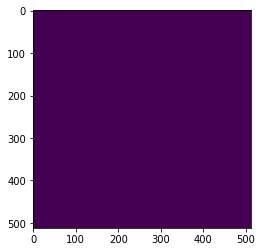

In [106]:
import matplotlib.pyplot as plt
plt.imshow(_preds[..., 0])

TypeError: Invalid shape (512, 512, 2) for image data

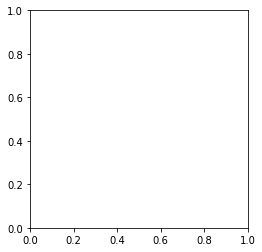

In [109]:
import matplotlib.pyplot as plt
plt.imshow(_preds)

In [63]:
_preds[..., 1]

array([[0.00195312, 0.00195312, 0.00195312, ..., 0.00195312, 0.00195312,
        0.00195312],
       [0.00195312, 0.00195312, 0.00195312, ..., 0.00195312, 0.00195312,
        0.00195312],
       [0.00195312, 0.00195312, 0.00195312, ..., 0.00195312, 0.00195312,
        0.00195312],
       ...,
       [0.00195312, 0.00195312, 0.00195312, ..., 0.00195312, 0.00195312,
        0.00195312],
       [0.00195312, 0.00195312, 0.00195312, ..., 0.00195312, 0.00195312,
        0.00195312],
       [0.00195312, 0.00195312, 0.00195312, ..., 0.00195312, 0.00195312,
        0.00195312]], dtype=float32)

Ground Truth


ValueError: operands could not be broadcast together with shapes (512,512,1) (3,) (224,224,3) 

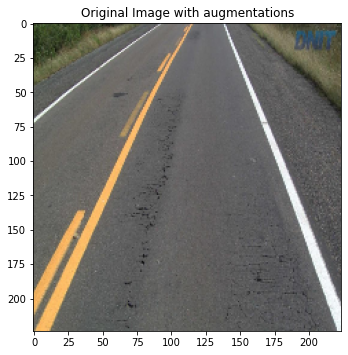

In [62]:
image = read_rgb(img_path)
image = cv2.resize(image, (224, 224))
print("Ground Truth")
visualize(
    image=image,
    masks=mask.detach().numpy().transpose(1, 2, 0),
    classes=["crack", "road", "pothole"],
    colors=colors
)